<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Small-example-of-single-edge-contribution" data-toc-modified-id="Small-example-of-single-edge-contribution-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Small example of single edge contribution</a></span><ul class="toc-item"><li><span><a href="#Define-QAOA-problem" data-toc-modified-id="Define-QAOA-problem-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Define QAOA problem</a></span><ul class="toc-item"><li><span><a href="#Create-graph" data-toc-modified-id="Create-graph-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Create graph</a></span></li><li><span><a href="#Create-QAOA-params" data-toc-modified-id="Create-QAOA-params-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Create QAOA params</a></span></li></ul></li><li><span><a href="#Calculate-Loss" data-toc-modified-id="Calculate-Loss-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Calculate Loss</a></span></li><li><span><a href="#Calculate-gradient" data-toc-modified-id="Calculate-gradient-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Calculate gradient</a></span></li><li><span><a href="#Do-gradient-descent" data-toc-modified-id="Do-gradient-descent-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Do gradient descent</a></span></li><li><span><a href="#Plot-parameter-space-with-descent-path" data-toc-modified-id="Plot-parameter-space-with-descent-path-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Plot parameter space with descent path</a></span></li></ul></li><li><span><a href="#Use-Adam-optimizer-(and-others)" data-toc-modified-id="Use-Adam-optimizer-(and-others)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Use Adam optimizer (and others)</a></span></li><li><span><a href="#Optimize-the-full-QAOA-cost" data-toc-modified-id="Optimize-the-full-QAOA-cost-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimize the full QAOA cost</a></span></li><li><span><a href="#Run-larger-optimizations" data-toc-modified-id="Run-larger-optimizations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run larger optimizations</a></span><ul class="toc-item"><li><span><a href="#Compare-time-with-numpy-simulator" data-toc-modified-id="Compare-time-with-numpy-simulator-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Compare time with numpy simulator</a></span></li></ul></li><li><span><a href="#Visualize-torch-dynamic-variable-graph" data-toc-modified-id="Visualize-torch-dynamic-variable-graph-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize torch dynamic variable graph</a></span></li><li><span><a href="#Small-playground-of-torch-autograd" data-toc-modified-id="Small-playground-of-torch-autograd-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Small playground of torch autograd</a></span><ul class="toc-item"><li><span><a href="#Incorrect-way" data-toc-modified-id="Incorrect-way-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Incorrect way</a></span></li><li><span><a href="#Correct-way" data-toc-modified-id="Correct-way-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Correct way</a></span></li></ul></li></ul></div>

# Optimizing variational parameters of Qantum Circuit

The goal of variational algorithms is to find a perfect set of parameters that minimize a particular cost.
For example, in the case of QAOA algorithm, one wants to minimize energy expectation of cost operator in state $\langle \gamma\beta|$. The cost function (or _loss_ in terms of machine learning) is $ L = \langle \gamma\beta | \hat C | \gamma \beta \rangle $

In [1]:
import qtensor
import networkx as nx
import numpy as np
from qtensor.contraction_backends import TorchBackend

In [2]:
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats
%matplotlib inline
__plot_height = 2.719
matplotlib.rcParams['figure.figsize'] = (1.618*__plot_height, __plot_height)
set_matplotlib_formats('svg')

In [3]:
%load_ext autoreload
%autoreload 2

## Small example of single edge contribution

### Define QAOA problem
#### Create graph

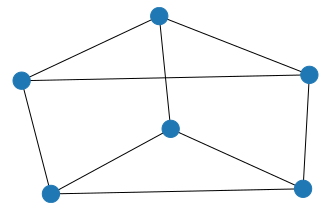

In [4]:
G = qtensor.toolbox.random_graph(nodes=6, degree=3, seed=10)
nx.draw_kamada_kawai(G)

#### Create QAOA params

The point `gamma, beta` is defined to be near a saddle point on purpose. 
This tests how vanilia gradient descent will perform in such cases.

In [5]:
p = 1
edge = list(G.edges)[0]

gamma, beta = [0.507]*p, [0.2507]*p
composer = qtensor.DefaultQAOAComposer(G, gamma=gamma, beta=beta)
composer.energy_expectation_lightcone(edge)
composer.circuit

[H(0),
 H(1),
 H(2),
 H(3),
 H(4),
 H(5),
 ZZ[alpha=1.01](0,1),
 ZZ[alpha=1.01](0,3),
 ZZ[alpha=1.01](0,4),
 ZZ[alpha=1.01](1,2),
 ZZ[alpha=1.01](1,5),
 XPhase[alpha=0.50](0),
 XPhase[alpha=0.50](1),
 Z(0),
 Z(1),
 XPhase+[alpha=0.50](1),
 XPhase+[alpha=0.50](0),
 ZZ+[alpha=1.01](1,5),
 ZZ+[alpha=1.01](1,2),
 ZZ+[alpha=1.01](0,4),
 ZZ+[alpha=1.01](0,3),
 ZZ+[alpha=1.01](0,1),
 H+(5),
 H+(4),
 H+(3),
 H+(2),
 H+(1),
 H+(0)]

In [6]:
sim_np = qtensor.QtreeSimulator()
sim_np.simulate(composer.circuit)

array([0.00038601-4.90653885e-18j])

### Calculate Loss

In [7]:
import torch

In [8]:
def torch_param(x):
    return torch.tensor(x, requires_grad=True)

In [9]:
gamma, beta = torch_param(gamma), torch_param(beta)

In [10]:
composer = qtensor.TorchQAOAComposer(G, gamma=gamma, beta=beta)
composer.energy_expectation_lightcone(edge)
composer.circuit

backend = TorchBackend()
sim = qtensor.QtreeSimulator(backend=backend)

In [11]:
sim.simulate(composer.circuit)

tensor([0.0004-1.6464e-09j], grad_fn=<ViewBackward>)

In [12]:
loss = -torch.real(sim.simulate(composer.circuit))
loss

tensor([-0.0004], grad_fn=<NegBackward>)

### Calculate gradient

In [13]:
loss.grad_fn

In [14]:
loss.backward(retain_graph=True)

/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


In [15]:
print('Gamma gradient =', gamma.grad)
print('Beta gradient =', beta.grad)

Gamma gradient = tensor([-0.0549])
Beta gradient = tensor([-0.5514])


### Do gradient descent


A helpful article about using bare-bones autograd in pytoch: https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e#40de

About complex-valued autograd: https://pytorch.org/docs/stable/notes/autograd.html#complex-autograd-doc

Since the common optimization problem in ML is minimization, we'll negate the loss.
This will help using advanced optimizers later

**Loss**

$$ L = - \Re( \langle \gamma \beta | \hat C | \gamma \beta \rangle) $$

In [16]:
lr = 3e-3
losses = []
steps = 20
param_history = []

In [17]:
gamma, beta = torch_param([0.507]*p), torch_param([0.2507]*p)

for i in range(steps):
    print()
    param_history.append((gamma.detach().numpy().copy(), beta.detach().numpy().copy()))
    composer = qtensor.TorchQAOAComposer(G, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    loss = -torch.real(sim.simulate(composer.circuit))
    losses.append(loss.detach().numpy())
    print('loss =', losses[-1])
    
    loss.backward(retain_graph=True)
    
    with torch.no_grad():
        gamma -= lr*gamma.grad
        beta -= lr*beta.grad
        
    print('Params', gamma, beta)
    print('Grads', gamma.grad, beta.grad)
    gamma.grad.zero_()
    beta.grad.zero_()


loss = [-0.00038602]
Params tensor([0.5072], requires_grad=True) tensor([0.2524], requires_grad=True)
Grads tensor([-0.0549]) tensor([-0.5514])

loss = [-0.00132851]
Params tensor([0.5077], requires_grad=True) tensor([0.2540], requires_grad=True)
Grads tensor([-0.1845]) tensor([-0.5641])

loss = [-0.0024583]
Params tensor([0.5087], requires_grad=True) tensor([0.2559], requires_grad=True)
Grads tensor([-0.3167]) tensor([-0.6070])

loss = [-0.00399847]
Params tensor([0.5100], requires_grad=True) tensor([0.2579], requires_grad=True)
Grads tensor([-0.4581]) tensor([-0.6802])

loss = [-0.00623141]
Params tensor([0.5119], requires_grad=True) tensor([0.2603], requires_grad=True)
Grads tensor([-0.6147]) tensor([-0.7854])

loss = [-0.00954458]
Params tensor([0.5143], requires_grad=True) tensor([0.2630], requires_grad=True)
Grads tensor([-0.7925]) tensor([-0.9247])

loss = [-0.01448263]
Params tensor([0.5173], requires_grad=True) tensor([0.2663], requires_grad=True)
Grads tensor([-0.9962]) tens

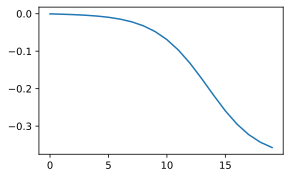

In [18]:
import matplotlib.pyplot as plt
plt.plot(losses)

### Plot parameter space with descent path

In [19]:
from cartesian_explorer import Explorer
ex = Explorer()

In [20]:
@ex.provider
def single_edge_contribution(graph, gamma, beta):
    composer = qtensor.DefaultQAOAComposer(graph, gamma=[gamma], beta=[beta])
    composer.circuit
    edge = list(graph.edges)[0]
    composer.energy_expectation_lightcone(edge)
    sim_np = qtensor.QtreeSimulator()
    return sim_np.simulate(composer.circuit)


In [21]:
gamma_arr = list(np.linspace(0, 1/1, 20))
beta_arr = list(np.linspace(0, 1/2, 20))

In [22]:
arr = ex.map_variable('single_edge_contribution', graph=[G], gamma=gamma_arr, beta=beta_arr)

In [23]:
print('Max value', np.real(arr).max())

Max value 0.38119001204643244


/home/plate/.local/lib/python3.8/site-packages/numpy/ma/core.py:2794: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


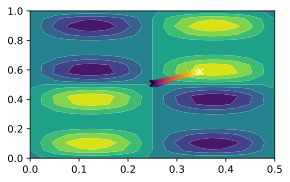

In [24]:
plt.contourf(beta_arr, gamma_arr, arr.reshape(len(gamma_arr), len(beta_arr)))

gammas, betas = zip(*param_history)
plt.scatter(betas, gammas, marker='x', c=range(len(param_history)), cmap='inferno')

---

## Use Adam optimizer (and others)

This optimizer will work even when the starting point is exactly the saddle point.
Gradient descent will not work in this case


Another good optimizer is Adagrad, which shows even better results for the saddle point.
However, it does not have momentum, so will tend to converge to local minima on more complicated surfaces.


An overview of different optimizers: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c

Short summary, in the order of advanceness:

- **Gradient descent** -- the simplest, good for demos;
- **Momentum** -- adds inertia to the parameter point, better handles local minima;
- **AdaGrad** -- better handling of saddle points through scaling of learning rate based on value of grads;
- **RMSProp** -- speeds up convergence of previous by adding decay to the learning rate factor;
- **Adam** -- momentum + RMSProp. 

The last three do not need learning rate tuning.

For this toy example the best is `RMSProp`, which converges in 5 (five!) steps from exactly the saddle point.

In [25]:
def get_loss(gamma, beta, G):
    composer = qtensor.TorchQAOAComposer(G, gamma=gamma, beta=beta)
    edge = list(G.edges)[0]
    composer.energy_expectation_lightcone(edge)
    loss = - torch.real(sim.simulate(composer.circuit))
    return loss

gamma, beta = torch_param([0.500]*p), torch_param([0.2500]*p)

opt = torch.optim.RMSprop(params=(gamma, beta))

In [26]:
losses = []
steps = 40
param_history = []
param_history.append((gamma.detach().numpy().copy(), beta.detach().numpy().copy()))

for i in range(steps):
    loss = get_loss(gamma, beta, G)
    opt.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function
    opt.step()
    
    losses.append(loss.detach().numpy().data)
    param_history.append((gamma.detach().numpy().copy(), beta.detach().numpy().copy()))

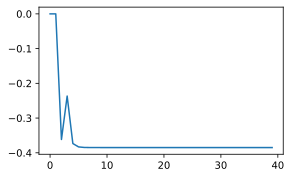

In [27]:
plt.plot(losses)

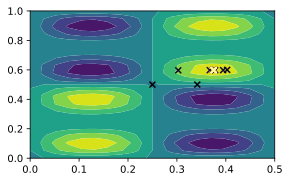

In [28]:
plt.contourf(beta_arr, gamma_arr, np.real(arr).reshape(len(gamma_arr), len(beta_arr)))

gammas, betas = zip(*param_history)
plt.scatter(betas, gammas, marker='x', c=range(len(param_history)), cmap='inferno')

## Optimize the full QAOA cost

The full cost is a sum of all the edge contributions.

In [29]:
def get_loss_full(gamma, beta, G=nx.Graph()):
    composer = qtensor.TorchQAOAComposer(G, gamma=gamma, beta=beta)
    loss = torch.tensor([0.])
    for edge in G.edges:
        composer.energy_expectation_lightcone(edge)
        loss += - torch.real(sim.simulate(composer.circuit))
        composer.builder.reset()
    return loss

def optimize_params(get_loss, *params, steps=50,
                    pbar=True,
                    Opt=torch.optim.RMSprop,
                    opt_kwargs=dict(),
                    **kwargs):
    
    opt = Opt(params=params, **opt_kwargs)
    losses = []
    steps = 40
    param_history = []
    param_history.append([x.detach().numpy().copy() for x in params])
    
    if pbar:
        from tqdm.auto import tqdm
        _pbar = tqdm(total=steps)
    else:
        _pbar = None

    for i in range(steps):
        loss = get_loss(*params, **kwargs)
        opt.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function
        opt.step()

        losses.append(loss.detach().numpy().data)
        param_history.append([x.detach().numpy().copy() for x in params])
        if pbar:
            _pbar.update(1)
    return losses, param_history

In [30]:
gamma, beta = torch_param([0.500]*p), torch_param([0.2500]*p)

Opt = torch.optim.RMSprop

losses, param_history = optimize_params(get_loss_full, gamma, beta, Opt=Opt, G=G)

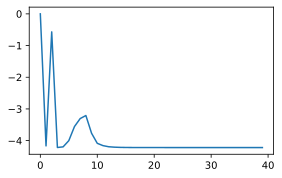

In [31]:
plt.plot(losses)

In [32]:
@ex.provider
def qaoa_energy_expectation(graph, gamma, beta):
    composer = qtensor.DefaultQAOAComposer(graph, gamma=[gamma], beta=[beta])
    results = []
    for edge in graph.edges:
        composer.energy_expectation_lightcone(edge)
        sim_np = qtensor.QtreeSimulator()
        res_ = sim_np.simulate(composer.circuit)
        results.append(res_)
        composer.builder.reset()
    return np.sum(results)

In [33]:
arr = ex.map_variable('qaoa_energy_expectation', graph=[G], gamma=gamma_arr, beta=beta_arr)

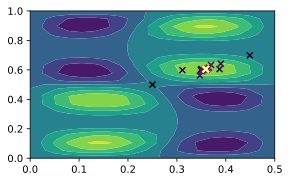

In [34]:
plt.contourf(beta_arr, gamma_arr, np.real(arr).reshape(len(gamma_arr), len(beta_arr)))

gammas, betas = zip(*param_history)
plt.scatter(betas, gammas, marker='x', c=range(len(param_history)), cmap='inferno')

## Run larger optimizations

In [35]:
p = 2
G_large = qtensor.toolbox.random_graph(nodes=20, degree=3, seed=10)
gamma, beta = torch_param([0.500]*p), torch_param([0.2500]*p)

In [36]:
Opt = torch.optim.RMSprop

losses, param_history = optimize_params(get_loss_full, gamma, beta, Opt=Opt, G=G_large)

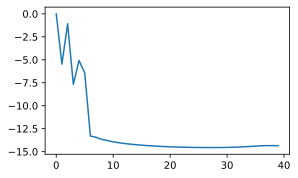

In [37]:
plt.plot(losses)

In [38]:
Opt = torch.optim.Adam
gamma, beta = torch_param([0.500]*p), torch_param([0.2500]*p)
losses, param_history = optimize_params(get_loss_full, gamma, beta,
                                        Opt=Opt,
                                        opt_kwargs=dict(lr=0.005, amsgrad=True),
                                        G=G_large)

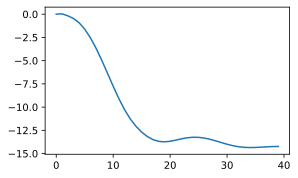

In [39]:
plt.plot(losses)

### Compare time with numpy simulator

In [40]:
%%time 
loss = get_loss_full(gamma, beta, G_large)
loss.detach().numpy()

CPU times: user 905 ms, sys: 0 ns, total: 905 ms
Wall time: 903 ms


array([-14.244123], dtype=float32)

In [41]:
%%time
sim_np = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer)
sim_np.energy_expectation(G_large, [0.1]*p, [0.3]*p)


CPU times: user 589 ms, sys: 72.7 ms, total: 662 ms
Wall time: 532 ms


array([17.34560576])

---

## Visualize torch dynamic variable graph

In [42]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot


In [43]:

p=1
gamma, beta = torch_param([0.500]*p), torch_param([0.2500]*p)
loss = get_loss(gamma, beta, G)

In [44]:
g = make_dot(loss, {'gamma':gamma, 'beta':beta})
g.view()


{140035796158144: 'gamma', 140035865414720: 'beta'}


'Digraph.gv.pdf'

---

## Small playground of torch autograd

In [45]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [46]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [47]:
gamma + 2

tensor([2.5000], grad_fn=<AddBackward0>)

In [48]:
from qtensor.OpFactory import TorchFactory, QtreeFactory

In [49]:
param = torch.tensor(0.13, requires_grad=True)
ZZ = TorchFactory.ZZ(0, 1, alpha=param)
ZZ.gen_tensor()

tensor([[0.9792-0.2028j, 0.9792+0.2028j],
        [0.9792+0.2028j, 0.9792-0.2028j]], grad_fn=<AddBackward0>)

In [50]:
import numpy as np
def torch_exp(z):
    """
    https://discuss.pytorch.org/t/complex-functions-exp-does-not-support-automatic-differentiation-for-outputs-with-complex-dtype/98039/3
    """
    return torch.cos(z) + 1j * torch.sin(z)

### Incorrect way

In [51]:
alpha = torch.tensor(0.13, requires_grad=True)
p = torch_exp(1j*np.pi*alpha/2)
m = torch_exp(-1j*np.pi*alpha/2)
tensor = torch.tensor([ [m, p] ,[p, m] ])

In [52]:
tensor

tensor([[1.2265+0.j, 0.8153+0.j],
        [0.8153+0.j, 1.2265+0.j]])

### Correct way

In [53]:
alpha = torch.tensor(0.13, requires_grad=True)
tensor = torch.tensor([[0, 1], [1, 0.]])
e_ = torch_exp(1j*np.pi*alpha/2)
tensor = tensor*e_
tensor

tensor([[0.0000+0.j, 0.8153+0.j],
        [0.8153+0.j, 0.0000+0.j]], grad_fn=<MulBackward0>)

In [54]:
tensor*torch.tensor([[0.1,0],[10,15]])

tensor([[0.0000+0.j, 0.0000+0.j],
        [8.1530+0.j, 0.0000+0.j]], grad_fn=<MulBackward0>)

In [55]:
tensor = torch.tensor([[-1, 1],[1, -1]])
torch_exp(1j*tensor*np.pi*alpha/2)

tensor([[1.2265+0.j, 0.8153+0.j],
        [0.8153+0.j, 1.2265+0.j]], grad_fn=<AddBackward0>)